In [4]:
import numpy as np
import sqlite3
import MDSplus as mds
import scipy.fftpack as fft

from scipy.signal import periodogram
from scipy.integrate import cumtrapz
from scipy.signal import periodogram
from scipy.optimize import curve_fit

import sys 
sys.path.append('..')

from write_to_vtk.read_unstructured_vtk import read_unstructured_vtk
from write_to_vtk import structured_3d_vtk as struc_3d



import read_from_sql.read_from_sql as read_from_sql

import fit_field_line_null
reload(fit_field_line_null)
from fit_field_line_null import find_field_null

from centroid_fitting import gyration_path
reload(gyration_path)
gyration_path = gyration_path.gyration_path

In [5]:
from laplace_solver import laplace_solver as l_solve
reload(l_solve)
import vector_calculus 
reload(vector_calculus)
from vector_calculus import vector_calculus as vc
reload(vc)
from vector_comparison import vector_taylor as vt
reload(vt)
from invert_curl import invert_curl as inv_curl
reload(inv_curl)
import itertools

In [6]:
from scipy.constants import proton_mass as m_i
from scipy.constants import elementary_charge as q_e
import scipy.fftpack as fft
from scipy.signal import boxcar, convolve

import sys 
sys.path.append('..')

from helicity_plots import plot_helicities
reload(plot_helicities)
compare_helicities = plot_helicities.compare_helicities
compare_helicities_mean_std = plot_helicities.compare_helicities_mean_std

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')

## Read Current & fiducial probe

In [7]:
bias_current_node_name = '\j_002_004'
fiducial_a_node_name = '\j_002_001'
fiducial_b_node_name = '\j_002_004'


In [8]:
database = '../shots_database/shots.db'
connection = sqlite3.connect('../shots_database/shots.db')
connection.row_factory = sqlite3.Row
cursor = connection.cursor()
cursor.execute("SELECT * FROM Shots")
rows = cursor.fetchall()
cursor.close()
connection.close()
first_shot = rows[0]
print first_shot['shot']
tree = mds.Tree('rsx', first_shot['shot'])

bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3

fiducial_a_node = tree.getNode('\j_002_000')
fiducial_b_node = tree.getNode('\j_002_001')
bias_current_node = tree.getNode('\j_002_004')
fiducial_a_data = fiducial_a_node.getData() 
fiducial_b_data = fiducial_b_node.getData()
fiducial_a_raw = np.asarray(fiducial_a_data.getValue())
fiducial_b_raw = np.asarray(fiducial_b_data.getValue())

delta_t = bias_current_time[1] - bias_current_time[0]
time = bias_current_time

15253


In [9]:
offset = fiducial_a_raw[20000:35000].mean()
fiducial_a = cumtrapz(fiducial_a_raw[20000:55000] - offset, dx=delta_t, initial=0)

In [10]:
factor = 6.5/fiducial_a.max()

# Gyration Onset Plot

In [24]:
import numpy as np
from scipy.optimize import curve_fit

def fit_func_pure_gauss(x, a0, a1, a2, a3):
    z = (x - a1) / (np.sqrt(2)*a2**2)
    y = a0 * np.exp(-z**2) + a3
    return y

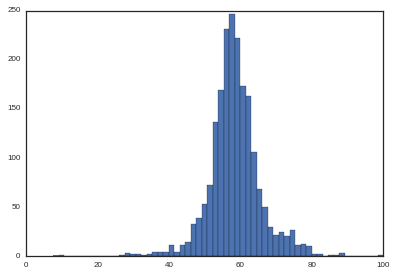

In [27]:
connection = sqlite3.connect(database)
cursor = connection.cursor()
cursor.execute("SELECT period FROM Shots WHERE (period IS NOT NULL and fiducial_pre_crowbar_gyration_spectral_density > " +
               str(1.6e-8) + ")")
periods = cursor.fetchall()
cursor.close()
connection.close()

periods = np.asarray(periods)
gyration_frequency = 1. / periods

n, bins, patches = plt.hist(gyration_frequency/1000, 60)
parameters, covariance = curve_fit(fit_func_pure_gauss, bins[:-1] + np.diff(bins)/2, n, p0=[250, 60, 2, 1e-3])



In [29]:
parameters

array([ 228.33076937,   57.94574377,    2.16421824,    4.28322013])

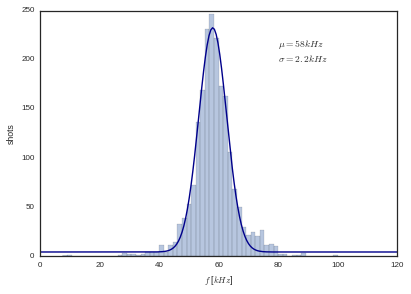

In [30]:
plt.plot(np.linspace(0, 120, 200), fit_func_pure_gauss(np.linspace(0, 120, 200), *parameters), color='darkblue')

axes = sns.distplot(gyration_frequency/1e3, axlabel=r'$f$ [$kHz$]', kde=False, bins=bins)
axes.set_ylabel('shots')
axes.text(80, 200, (r"$\mu = 58 kHz$"
                    "\n" 
                    r"$\sigma=2.2 kHz$"))
plt.show()

In [37]:
(gyration_frequency/1e3).std()

7.3089557359054531

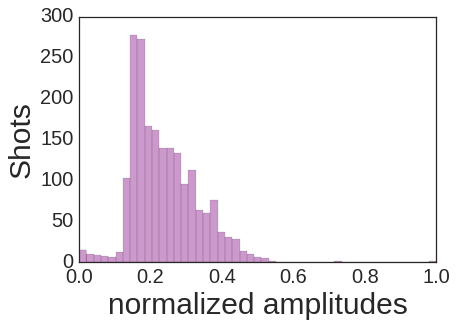

In [38]:
connection = sqlite3.connect(database)
cursor = connection.cursor()
cursor.execute("SELECT uncalibrated_integrated_fiducial_a_gyration_amplitude FROM Shots WHERE" +
" (fiducial_pre_crowbar_gyration_spectral_density > 1.6e-8 and period IS NOT NULL)")
amplitudes = cursor.fetchall()
cursor.close()
connection.close()

amplitudes = np.asarray(amplitudes)
amplitudes = amplitudes / amplitudes.max()

axes = sns.distplot(amplitudes, axlabel=r'normalized amplitudes', color='purple', kde=False)
plt.tick_params(axis='both', which='major', labelsize=20)
axes.set_xlabel(axes.get_xlabel(), fontsize=30)
axes.set_ylabel('Shots', fontsize=30)

In [42]:
amplitudes.std()

0.092381074661462975

In [43]:
amplitudes.mean()

0.23734392651118663

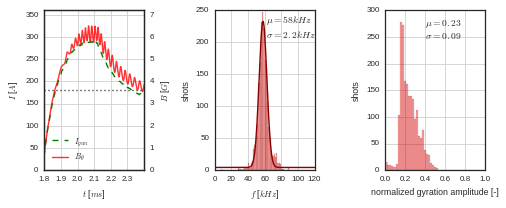

In [44]:
fig, axes1 = plt.subplots(1, 3, figsize=(7, 3.0))

axes1[0].plot(bias_current_time[20000:55000:100]*1e3, 
           bias_current[20000:55000:100]*2e3, 
           c='green', ls='--', label=r'$I_{gun}$')
axes2 = axes1[0].twinx()
axes2.plot(bias_current_time[20000:55000]*1e3, 
           fiducial_a*factor, c='red', alpha=0.8,
           label=r'$B_{\theta}$')

axes1[0].axhline(180, c='black', ls=':')

lines1, labels1 = axes1[0].get_legend_handles_labels()
lines2, labels2 = axes2.get_legend_handles_labels()

axes1[0].legend(lines1 + lines2, labels1 + labels2, loc='best')


axes1[0].set_xlim(1.8, 2.4)
axes1[0].set_ylim(0, 360)
axes2.set_ylim(0, 7.2)
axes1[0].grid()
axes1[0].set_xlabel(r"$t$ [$ms$]")
axes1[0].set_ylabel(r"$I$ [$A$]")
axes2.set_ylabel(r"$B$ [$G$]")

axes1[1].plot(np.linspace(0, 120, 200), fit_func_pure_gauss(np.linspace(0, 120, 200), *parameters), color='darkred')

axes1[1] = sns.distplot(gyration_frequency/1e3, axlabel=r'$f$ [$kHz$]', kde=False, bins=bins, color='red', ax=axes1[1])
axes1[1].set_ylabel('shots')
axes1[1].set_xlabel(r'$f$ [$kHz$]')
axes1[1].text(62, 210, (r"$\mu = 58 kHz$"
                    "\n" 
                    r"$\sigma=2.2 kHz$"))
axes1[1].grid()


axes1[2] = sns.distplot(amplitudes, axlabel=r'normalized gyration amplitude [-]', color='red', kde=False, ax=axes1[2])
axes1[2].set_ylabel('shots')
axes1[2].text(0.4, 250, (r"$\mu = 0.23$"
                    "\n" 
                    r"$\sigma=0.09$"))
axes1[2].grid()

fig.tight_layout()
plt.show()
fig.savefig('gyration_onset.png', dpi=600)

# Spectral power discussion

In [45]:
fs = 1./(time[1] - time[0])

condition_strong = ("fiducial_pre_crowbar_gyration_spectral_density > " +
                    str(1.6e-6))
cursor, connection = read_from_sql.cursor_with_rows(condition_strong,
                                                    database,
                                                    'Shots')
shots = cursor.fetchall()
fiducials_strong = []
for i in xrange(10):
    shot = shots[i]['shot']
    fiducial_a_node_name = shots[i]['fiducial_a_node']
    fiducial_a_node = tree.getNode(fiducial_a_node_name)
    tree = mds.Tree('rsx', shot)
    fiducial_a_data = fiducial_a_node.getData() 
    fiducial_a_raw = np.asarray(fiducial_a_data.getValue())
    fiducials_strong.append(fiducial_a_raw)
    time = np.asarray(fiducial_a_data.getDimensions()[0])*1e-3
    
psds_strong = []
for fiducial_strong in fiducials_strong:
    freqs, psd_strong = periodogram(fiducial_strong[35000:42300], fs)
    psds_strong.append(psd_strong)
psds_strong = np.asarray(psds_strong)
average_psd_strong = np.mean(psds_strong, axis=0)

read_from_sql.close(connection, cursor)

In [76]:
condition_weak = ("fiducial_pre_crowbar_gyration_spectral_density < " +
                  str(1.6e-9))
cursor, connection = read_from_sql.cursor_with_rows(condition_weak,
                                                    database,
                                                    'Shots')
shots = cursor.fetchall()
fiducials_weak = []
for i in xrange(10):
    shot = shots[i]['shot']
    fiducial_a_node_name = shots[i]['fiducial_a_node']
    fiducial_a_node = tree.getNode(fiducial_a_node_name)
    tree = mds.Tree('rsx', shot)
    fiducial_a_data = fiducial_a_node.getData() 
    fiducial_a_raw = np.asarray(fiducial_a_data.getValue())
    fiducials_weak.append(fiducial_a_raw)
    time = np.asarray(fiducial_a_data.getDimensions()[0])*1e-3
psds_weak = []
for fiducial_weak in fiducials_weak:
    freqs, psd_weak = periodogram(fiducial_weak[35000:42300], fs)
    psds_weak.append(psd_weak)
psds_weak = np.asarray(psds_weak)
average_psd_weak = np.mean(psds_weak, axis=0)

read_from_sql.close(connection, cursor)

In [47]:
np.where(np.allclose(freqs, 5e4, atol=1e-1))

(array([], dtype=int64),)

1.60292091451e-05


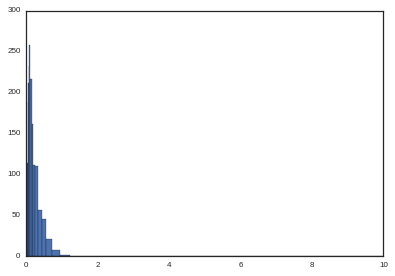

In [70]:
connection = sqlite3.connect(database)
cursor = connection.cursor()
cursor.execute("SELECT fiducial_pre_crowbar_gyration_spectral_density FROM Shots WHERE fiducial_pre_crowbar_gyration_spectral_density IS NOT NULL")
spectral_density = cursor.fetchall()
cursor.close()
connection.close()


spectral_density = np.asarray(spectral_density)
print spectral_density.max()
spectral_density = spectral_density / spectral_density.max() 

n, bins, patches = plt.hist(spectral_density, bins=np.logspace(-8, 1, 10*8))
parameters, covariance = curve_fit(fit_func_pure_gauss, np.log10(bins[:-1] + np.diff(bins)/2), n, p0=[250, -1, 1, 1e-3])


In [71]:
parameters

array([ 237.81550732,   -1.04673632,    0.60311052,    2.08474092])

In [72]:
spectral_density.mean()

0.12204070861976679

In [73]:
10**(-1.0467)

0.08980489305127522

In [74]:
10**(0.6031)

4.009590312277195

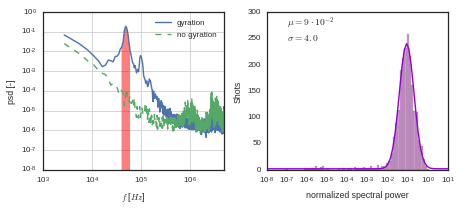

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(6.5,3))
axes[0].loglog(freqs, average_psd_strong/10**-8, label='gyration')
axes[0].loglog(freqs, average_psd_weak/10**-8, ls='--', label='no gyration')
axes[0].fill_between(freqs[15:23], 
                     average_psd_strong[15:23]/10**-8, 
                     1e-14, alpha=0.5, color='r')
axes[0].set_xlim(10e2, 5e6)
axes[0].set_ylim(1e-8, 1e-0)
#plt.loglog(freqs, freqs**-(5./3.)/6e3)
axes[0].set_xlabel(r"$f$ [$Hz$]")
axes[0].set_ylabel(r"psd [-]")
axes[0].legend(loc='best')
axes[0].grid()

axes[1] = sns.distplot(spectral_density, axlabel=r'normalized spectral power', 
                       color='purple', bins=bins, kde=False, ax=axes[1])
axes[1].set_xscale('log')
#axes[1].set_xlabel(axes[1].get_xlabel(), fontsize=30)
axes[1].set_ylabel('Shots')
axes[1].plot(bins, fit_func_pure_gauss(np.log10(bins), *parameters), color='darkviolet')
#plt.tick_params(axis='both', which='major', labelsize=20)
axes[1].text(10**-7, 250, (r"$\mu = 9 \cdot 10^{-2}$"
                           "\n" 
                           r"$\sigma=4.0$"))

plt.tight_layout()
fig.savefig('rsx_fourier_spectrum.png', dpi=600)

# Gyration path

In [78]:
def get_interpolations(time_point):
    in_dir = ('../../output/filtered_unstructured_measurements/' + 
              '2017-04-17-16-44' + '/')
    in_file = '_filtered_unstructured_'

    centroids = []


    bxby_extents = {0: [-0.027, 0.025, -0.057, 0.040, 0.249, 0.416],
                    1: [-0.027, 0.027, -0.073, 0.041, 0.249, 0.416],
                    2: [-0.047, 0.031, -0.021, 0.028, 0.249, 0.416],
                    3: [-0.061, 0.031, -0.026, 0.03,  0.249, 0.416]}
    bz_extents = {0: [-0.027, 0.025, -0.06, 0.041, 0.249, 0.416],
                  1: [-0.27, 0.027, -0.076, 0.041, 0.249, 0.416],
                  2: [-0.044, 0.031, -0.021, 0.03, 0.249, 0.416],
                  3: [-0.072, 0.031, -0.026, 0.03, 0.249, 0.416]}

    bxby_extent = bxby_extents[0]
    bz_extent = bz_extents[0]



    time_str = str(time_point).zfill(4)
    bx_points, bx_values = read_unstructured_vtk(in_dir + 'bx' +
                                                 in_file + time_str + '.vtk')
    by_points, by_values = read_unstructured_vtk(in_dir + 'by' +
                                                 in_file + time_str + '.vtk')
    #bz_points, bz_values = read_unstructured_vtk(in_dir + 'bz' +
    #                                             in_file + time_str + '.vtk')
    print np.unique(bx_points[:, 2])
    z_value = np.unique(bx_points[:, 2])[0]
    print z_value
    
    z_index = np.where(bx_points[:, 2] == z_value)[0]
    bx_points = bx_points[z_index, :-1]
    bx_values = bx_values[z_index]
    z_index = np.where(by_points[:, 2] == z_value)[0]
    by_points = by_points[z_index, :-1]
    by_values = by_values[z_index]
    #z_index = np.where(bz_points[:, 2] == z_value)[0]
    #bz_points = bz_points[z_index, :-1]
    #bz_values = bz_values[z_index]

    bx_interpolator = struc_3d.get_interpolator(bx_points, bx_values)
    by_interpolator = struc_3d.get_interpolator(by_points, by_values)
    #bz_interpolator = struc_3d.get_interpolator(bz_points, bz_values)
    grid_extent = [bxby_extent[0], bxby_extent[1],
                   bxby_extent[2], bxby_extent[3]]
    grid = np.meshgrid(np.linspace(grid_extent[0], grid_extent[1],
                                   (grid_extent[1] - grid_extent[0])/
                                    0.001),
                       np.linspace(grid_extent[2], grid_extent[3],
                                   (grid_extent[3] - grid_extent[2])/
                                    0.001))
    return grid, bx_interpolator, by_interpolator

In [79]:
(grid, bx_interpolator, 
 by_interpolator) = get_interpolations(0)
b_field_x = bx_interpolator(grid[0], grid[1])
b_field_y = by_interpolator(grid[0], grid[1])
b_fields = [b_field_x, b_field_y]
grid = np.asarray(grid)

[ 0.419]
0.418999999762


In [80]:
(field_null, center_points,
 radii, streamlines, 
 max_index) = find_field_null(grid, bx_interpolator, by_interpolator)

In [81]:
field_null_directory = '/home/jensv/rsx/jens_analysis/output/field_nulls/' 
field_null_timestamps = ('2017-04-12-10-09',
                         '2017-04-17-18-49',
                         '2017-04-17-19-00',
                         '2017-04-17-19-12',
                         '2017-04-17-19-22',
                         '2017-04-17-19-42',
                         '2017-04-17-19-48', 
                         '2017-04-17-19-56',
                         '2017-04-17-20-04',
                         '2017-04-17-20-09',
                         '2017-04-17-20-14')
field_null_file = '/field_nulls.txt'

timestamp = field_null_timestamps[0]
field_null_path = field_null_directory + timestamp + field_null_file
points = np.loadtxt(field_null_path)[:, :, np.newaxis]

for timestamp in field_null_timestamps[1:-1]:
    field_null_path = field_null_directory + timestamp + field_null_file
    points = np.append(points, np.loadtxt(field_null_path)[:, :, np.newaxis],
                       axis=2)
points_average = np.mean(points, axis=2)
points_std = np.std(points, axis=2, ddof=1)

0.00992155679827 0.0135060679373 0.0258147197577
(array([ 0.00992156,  0.01350607,  0.02581472]), 1)


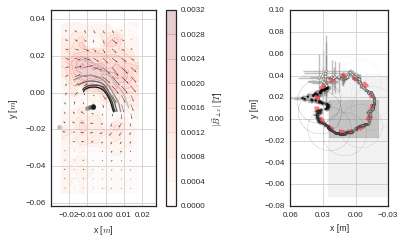

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(6.5,3.5))

gyration_path(points=points_average, errors=points_std, errorevery=1,
              circle_fit=True, xlim=(-0.03, 0.06), circles=True, 
              xticks=[-0.03, 0.0, 0.03, 0.06], axes=axes[1])

magnitude = np.sqrt(b_fields[0][:, :]**2 + b_fields[0][:, :]**2)
axes[0].quiver(grid[0, :, :][::5, ::5], grid[1, :, :][::5, ::5],
b_fields[0][:, :][::5, ::5], b_fields[1][:, :][::5, ::5])
contour = axes[0].contourf(grid[0, :, :], grid[1, :, :],
magnitude, alpha=0.2, cmap='Reds')
cb = plt.colorbar(contour, ax=axes[0], 
                  label=r"$|\vec{B}_{\perp z}|$ [$T$]")

colors = np.linspace(0.75, 0.1, 5)
colors = [str(color) for color in colors]

for i in range(5):
    length = streamlines[i][:,0].size
    axes[0].plot(streamlines[i][:,0][:length/2], 
                 streamlines[i][:,1][:length/2], 
                 c=colors[i])
    axes[0].plot(streamlines[i][:,0][length/2:], 
                 streamlines[i][:,1][length/2:], 
                 c=colors[i])
    axes[0].scatter(center_points[i][0], 
                    center_points[i][1], 
                    color=colors[i])
axes[0].set_xlabel(r'x [$m$]')
axes[0].set_ylabel(r'y [$m$]')

axes[1].grid()
axes[0].grid()

#plt.scatter(field_null[0], field_null[1], c='black', s=30)
#circle = plt.Circle((p1[0], p1[1]), p1[2], fill=False)
#axes.add_artist(circle)
axes[0].set_aspect('equal')
fig.tight_layout()
fig.savefig('gyration_path.png', dpi=600)

# Vector comparison for Laplace solver

In [84]:
reload(vt)
point_numbers = [5, 10, 20, 50]
fields = []
labels = [r'$\Delta$ = %1.2f' % (1./point_numbers[0]), 
          r'$\Delta$ = %1.2f' % (1./point_numbers[1]), 
          r'$\Delta$ = %1.2f' % (1./point_numbers[2]),
          r'$\Delta$ = %1.2f' % (1./point_numbers[3])]
for points_number in  point_numbers:
    mesh, A_x, A_y, A_z, B_x, B_y, B_z = vc.field_from_wire(limits=(3, 4, 3, 4, 3, 4),
                                                            wire_along_axis='y',
                                                            points=(points_number,
                                                                    points_number,
                                                                    points_number))
    boundary = np.zeros(mesh[0].shape)
    boundary[:, 0, :] = B_x[:, 0, :]
    boundary[:, -1, :] = B_x[:, -1, :]
    boundary[0, :, :] = B_y[0, :, :]
    boundary[-1, :, :] = B_y[-1, :, :]
    boundary[:, :, 0] = B_z[:, :, 0]
    boundary[:, :, -1] = B_z[:, :, -1]
    scalar_potential =  l_solve.laplace_3d_dct_fd(mesh, boundary)
    B_from_laplace_scalar_potential = vc.gradient(scalar_potential)
    fields.append(np.array(B_from_laplace_scalar_potential))
    
fields[1] = fields[1][:, ::2, ::2, ::2]
fields[2] = fields[2][:, ::4, ::4, ::4]
fields[3] = fields[3][:, ::10, ::10, ::10]
ref_field = np.asarray([B_x, B_y, B_z])[:, ::10, ::10, ::10]

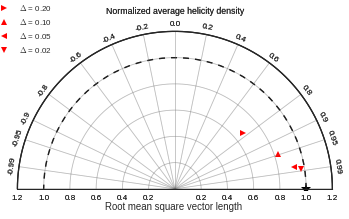

In [85]:
fig = plt.figure(figsize=(6.5, 3))
diagram = vt.calc_and_plot(ref_field,  
                 fields,
                 labels=labels,
                 std_multiplier=1.2, 
                 markers=[">", "^", "<", "v"], fig=fig, axes=None,
                 bbox_to_anchor=[0.03, 1.2],
                 r_locations=np.arange(-1.4, 1.4, 0.2),
                 r_label_pos=(0.35, 0.01), norm_rmsl=True)
plt.tight_layout()
fig.savefig('laplace_quality.png', dpi=600)

# vector field reconstruction in path

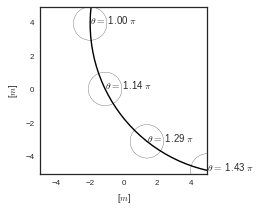

In [423]:
fig = plt.figure(figsize=(3.5, 3))
axes = plt.gca()

xlims = (-5, 5)
ylims = (-5, 5)
angles = np.linspace(0, 2.*np.pi, 250)
rot_center = [7., 4.]
radius = 9
x_wire_center = np.cos(angles)*radius + rot_center[0]
y_wire_center = np.sin(angles)*radius + rot_center[1]

axes.plot(x_wire_center, y_wire_center, c='black')

angles = np.linspace(0, 2.*np.pi, 15)
rot_center = [7., 4.]
radius = 9
x_wire_center = np.cos(angles)*radius + rot_center[0]
y_wire_center = np.sin(angles)*radius + rot_center[1]

for angle in angles:
    x_wire_center = np.cos(angle)*radius + rot_center[0]
    y_wire_center = np.sin(angle)*radius + rot_center[1]
    circle = plt.Circle((x_wire_center, y_wire_center), 1., fill=None)
    axes.add_artist(circle)
    if (xlims[0] < x_wire_center < xlims[1] and

        
        ylims[0] < y_wire_center < ylims[1]):
        axes.text(x_wire_center, y_wire_center, r'$\theta = $ %1.2f $\pi$' % (angle/np.pi))
    

axes.set_xlim(xlims[0], xlims[1])
axes.set_ylim(ylims[0], ylims[1])

axes.set_xlabel(r'[$m$]')
axes.set_ylabel(r'[$m$]')

axes.set_aspect('equal')

plt.savefig('vector_potential_test.png', dpi=600)

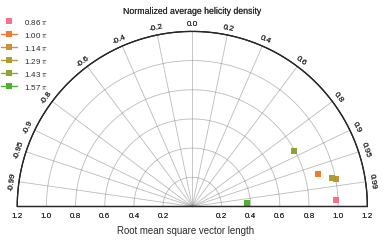

In [424]:
start = 6
end = 12
rmsls = []
similarities = [] 
fields = []
labels = [r"%1.2f $\pi$" % (angle/np.pi) for angle in angles[start:end]]
palette = itertools.cycle(sns.color_palette("husl", 15))
for angle in angles[start:end]:
    x_wire_center = np.cos(angle)*radius + rot_center[0]
    y_wire_center = np.sin(angle)*radius + rot_center[1]
    mesh, A_x, A_y, A_z, B_x, B_y, B_z = vc.field_from_wire(limits=(-5, 5, -5, 5, -5, 5),
                                                            wire_along_axis='y', 
                                                            center=[x_wire_center, 
                                                                    y_wire_center],
                                                            a=1)
    A_from_curl_inversion = inv_curl.devore_invert_curl(mesh, [B_x, B_y, B_z])
    B_from_curl_inversion = vc.curl(A_from_curl_inversion, mesh=mesh)
    fields.append(np.array(B_from_curl_inversion))
    rmsls.append(vt.root_mean_square_lenth(B_from_curl_inversion))
    similarities.append(vt.vector_simililarity_coefficient(np.array([B_x, B_y, B_z]),
                                                           B_from_curl_inversion))
rmsls = np.asarray(rmsls)
rmsls = rmsls/rmsls.max()
x_wire_center = np.cos(angles[start])*radius + rot_center[0]
y_wire_center = np.sin(angles[start])*radius + rot_center[1]
mesh, A_x, A_y, A_z, B_x, B_y, B_z = vc.field_from_wire(limits=(-5, 5, -5, 5, -5, 5),
                                                        wire_along_axis='y', 
                                                        center=[x_wire_center, 
                                                                y_wire_center],
                                                        a=1)

diagram = vt.calc_and_plot(np.array([B_x, B_y, B_z]),
                           [np.array(fields[0]),], colors=[next(palette),], 
                           std_multiplier=1.2, labels=[labels[0],], 
                           noref=True, r_label_pos=(0.35, 0.15), norm_rmsl=True,
                           r_locations=np.arange(-1.4, 1.4, 0.2))
for i in range(1, len(rmsls)):
    diagram.add_sample(rmsls[i], similarities[i], 
                       marker='s', color=next(palette), label=labels[i])
diagram.ax.legend(bbox_to_anchor=[.03, 1.1],
                  loc='upper center',
                  borderaxespad=0.25)
plt.savefig('vector_potential_quality.png', dpi=600)

# Helicity Plots

In [8]:
time = np.arange(250)*0.064

dates_by_sigma = {0.0: '2017-05-05-12-27',
                  0.5: '2017-05-05-12-35',
                  1.0: '2017-05-05-12-44',
                  1.5: '2017-05-05-12-53',
                  #2.0: '2017-05-05-13-02',
                  2.5: '2017-05-05-13-11',
                  3.0: '2017-05-05-13-21',
                  3.5: '2017-05-05-13-30',
                  4.0: '2017-05-05-13-40',
                  4.5: '2017-05-05-13-50',
                  5.0: '2017-05-05-14-00'}

helicities_by_sigma = {}

for sigma in dates_by_sigma.keys():
    date = dates_by_sigma[sigma]
    path = '../../output/helicity/' + date + '/'
    kinetic_helicity = np.loadtxt(path + 'kinetic_helicity_raw_vorticity_n_dependence.txt')
    kinetic_helicity_smoothed_vorticity = np.loadtxt(path + 'kinetic_helicity_n_dependence.txt')
    cross_helicity = np.loadtxt(path + 'cross_helicity_n_dependence.txt')
    magnetic_helicity = np.loadtxt(path + 'magnetic_helicity_n_dependence.txt')
    relative_cross_helicity = np.loadtxt(path + 'relative_cross_helicity_raw_vorticity_n_dependence.txt')
    relative_kinetic_helicity = np.loadtxt(path + 'relative_kinetic_helicity_raw_vorticity_n_dependence.txt')
    relative_cross_helicity_smoothed_vorticity = np.loadtxt(path + 'relative_cross_helicity_n_dependence.txt')
    relative_kinetic_helicity_smoothed_vorticity = np.loadtxt(path + 'relative_kinetic_helicity_n_dependence.txt')
    relative_magnetic_helicity = np.loadtxt(path + 'relative_magnetic_helicity_n_dependence.txt')
    time = np.arange(0, 250) * 0.068
    density_weighted = {'kinetic': np.roll(kinetic_helicity, 125),
                        'cross': np.roll(cross_helicity, 125), 
                        'magnetic': np.roll(magnetic_helicity, 125),
                        'relative_kinetic': np.roll(relative_kinetic_helicity, 125),
                        'relative_cross': np.roll(relative_cross_helicity, 125),
                        'relative_magnetic': np.roll(relative_magnetic_helicity, 125),
                        'kinetic_smoothed_vorticity': np.roll(kinetic_helicity_smoothed_vorticity, 125),
                        'relative_kinetic_smoothed_vorticity': np.roll(relative_kinetic_helicity_smoothed_vorticity, 125),
                        'relative_cross_smoothed_vorticity': np.roll(relative_cross_helicity_smoothed_vorticity, 125),
                        'time': time}
    helicities_by_sigma[sigma] = density_weighted
    
sigmas = [0.0, 0.5, 1.0, 1.5, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

In [9]:
field_null_directory = '/home/jensv/rsx/jens_analysis/output/field_nulls/' 
field_null_timestamps = ('2017-04-12-10-09',
                         '2017-04-17-18-49',
                         '2017-04-17-19-00',
                         '2017-04-17-19-12',
                         '2017-04-17-19-22',
                         '2017-04-17-19-42',
                         '2017-04-17-19-48', 
                         '2017-04-17-19-56',
                         '2017-04-17-20-04',
                         '2017-04-17-20-09',
                         '2017-04-17-20-14')
field_null_file = '/field_nulls.txt'

timestamp = field_null_timestamps[0]
field_null_path = field_null_directory + timestamp + field_null_file
points = np.loadtxt(field_null_path)[:, :, np.newaxis]

for timestamp in field_null_timestamps[1:-1]:
    field_null_path = field_null_directory + timestamp + field_null_file
    points = np.append(points, np.loadtxt(field_null_path)[:, :, np.newaxis],
                       axis=2)
points_average = np.mean(points, axis=2)
points_std = np.std(points, axis=2, ddof=1)

In [10]:
relative_kinetic = helicities_by_sigma[0.0]['relative_kinetic'][:, np.newaxis]
relative_cross = helicities_by_sigma[0.0]['relative_cross'][:, np.newaxis]
relative_magnetic = helicities_by_sigma[0.0]['relative_magnetic'][:, np.newaxis]
for sigma in sigmas[0::2]:
    relative_kinetic = np.append(relative_kinetic,
                                 helicities_by_sigma[sigma]['relative_kinetic'][:, np.newaxis],
                                 axis=1)
    relative_cross = np.append(relative_cross,
                               helicities_by_sigma[sigma]['relative_cross'][:, np.newaxis],
                               axis=1)
    relative_magnetic = np.append(relative_magnetic,
                                  helicities_by_sigma[sigma]['relative_magnetic'][:, np.newaxis],
                                  axis=1)
relative_kinetic_mean = np.mean(relative_kinetic, axis=1)
relative_cross_mean = np.mean(relative_cross, axis=1)
relative_magnetic_mean = np.mean(relative_magnetic, axis=1)
relative_kinetic_std = np.std(relative_kinetic, axis=1, ddof=1)
relative_cross_std = np.std(relative_cross, axis=1, ddof=1)
relative_magnetic_std = np.std(relative_magnetic, axis=1, ddof=1)

helicities  = {'time': time,
               'relative_magnetic': relative_magnetic_mean,
               'relative_cross': relative_cross_mean, 
               'relative_kinetic': relative_kinetic_mean}

helicities_std = {'relative_magnetic': relative_magnetic_std,
                  'relative_cross': relative_cross_std, 
                  'relative_kinetic': relative_kinetic_std}

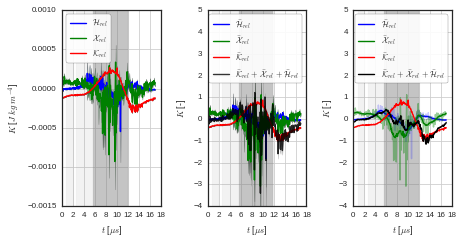

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(6.5, 3.5))
compare_helicities_mean_std(helicities,
                             helicities_std,
                             S_0_velocity=None,
                             nondim=False,
                             magnetic=False, kinetic=False, cross=False,
                             normalize=False,
                             labels_case="default",
                             add_cross_magnetic=False, axes=axes[0])
compare_helicities(helicities, 
                   S_0_velocity='u_alfven',
                   nondim=True,
                   magnetic=False, kinetic=False, cross=False,
                   normalize='relative_magnetic',
                   labels_case="dimless",
                   filter_width_kinetic=15, 
                   filter_width_cross=15, ylim=(-4, 5),
                   add_cross_magnetic=False, add_three=True, axes=axes[2])
compare_helicities_mean_std(helicities,
                            helicities_std,
                            S_0_velocity='u_alfven',
                            nondim=True,
                            magnetic=False, kinetic=False, cross=False,
                            normalize='relative_magnetic',
                            labels_case="dimless",
                            ylim=(-4, 5),
                            add_cross_magnetic=False, add_three=True, axes=axes[1])
axes[0].grid()
axes[1].grid()
axes[2].grid()
plt.tight_layout()
plt.savefig('helicities.png', dpi=600)